# Analyze autophagic bodies wrapped by vacuole membrane

The goal is to find the wrapped part of the autophagic body and to measure the intermembrane distance in this part.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyvista as pv
from pyvistaqt import BackgroundPlotter

# Import custom functions
dir_utilities = Path('../utilities').resolve().as_posix()
if dir_utilities not in sys.path:
    sys.path.insert(0, dir_utilities)
    
from utility_functions import (load_segmentation_tif, angle_between_vectors_batch, normalize_vector)
from distance_functions import minimum_distance_cleaned
from fitting_functions import (ls_sphere_3, ellipsoid_fit_rmse, fit_plane,
                               generate_ellipsoid_even, generate_sphere_even)
from fit_ellipsoid_weiss import fit_ellipsoid_iter, check_convergence_ellipsoid_fit


## Input

In [2]:
# Input segmentation file and pixel size
fname_in = Path('../example_data/wrapped_AB_analysis/wrapped_AB_middle_labels.tif')
pix_size = 1.408

# Segmentation labels
seg_labels = {'AB': 1,
              'vac': 2}

# Ellipsoid fitting
max_sphere_rmse_frac = 0.05 # If sphere fit rmse is worse than max_sphere_rmse_frac*radius, perform ellipsoid fit
n_iter_ellipsoid_fit = 50000

In [22]:
# For visualization
window_size_0 = [512,512]
cpos = {'points': [(-332.37301631602924, 1600.721526869876, -581.8680011674332),
                  (399.0, 649.5, 143.5),
                  (0.10452928757889257, 0.6526257809940411, 0.7504353523256796)],
        'plane': [(-423.06116703366826, 168.72026419661492, -1052.5123042858559),
                  (357.22816038131714, 649.5, 114.97161865234375),
                  (-0.4966446808383552, 0.8675838168124719, -0.025345252022257347)],
        'points_old': [(-111.94497078985088, 1354.1517443596088, -621.4371553980841),
                      (399.0, 649.5, 143.5),
                      (-0.06575220795906156, 0.7116327769178147, 0.6994679677903402)]}

## Load and process segmentation data

In [4]:
points = load_segmentation_tif(fname_in.as_posix(), seg_labels, verbose=True)

Input volume shape is (928, 928, 292)


In [5]:
p0 = BackgroundPlotter(window_size=window_size_0)
p0.enable_eye_dome_lighting()

p0.add_mesh(points['AB'], color='lightgreen')
p0.add_mesh(points['vac'], color='white')

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x2b47d03d2980

In [6]:
p0.saved_camera_positions

[[(-332.37301631602924, 1600.721526869876, -581.8680011674332),
  (399.0, 649.5, 143.5),
  (0.10452928757889257, 0.6526257809940411, 0.7504353523256796)]]

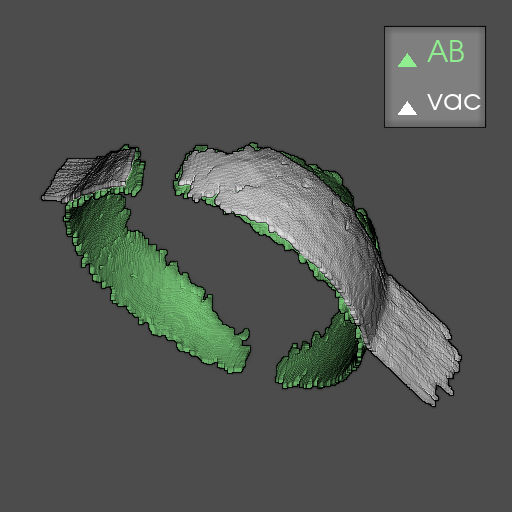

In [8]:
# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0) 
p0.enable_eye_dome_lighting()
colors = ['lightgreen', 'white']
for i, (key, p) in enumerate(points.items()):
    p0.add_mesh(p, color = colors[i], label=key)
p0.add_legend()
p0.camera_position = cpos['points']
_ = p0.show()

## Sphere fit of autophagic body

For size measurement and later refinement of distances.

In [9]:
# Perform sphere fit
d_sphere = {}
d_sphere['center'], d_sphere['radius'], d_sphere['rmse'] = ls_sphere_3(points['AB']) # least squares fit
for param in ['radius', 'rmse']:
    d_sphere[param+'_nm'] = d_sphere[param]*pix_size
    
print("Sphere fit: radius is {:.1f} nm, rmse is {:.1f} nm.".format(d_sphere['radius_nm'], d_sphere['rmse_nm']))

# Save results in d_fit
d_fit = {'sphere': d_sphere}

# Check if sphere fit is good enough of if an ellipsoid should be performed
sphere_rmse_vs_radius = d_sphere['rmse']/d_sphere['radius']
use_sphere_surf = True

# Ellipsoid fit if needed
if sphere_rmse_vs_radius > max_sphere_rmse_frac:
    print('Sphere fit rmse is high, try ellipsoid fit')
    # If sphere rmse is too high, try ellipsoid fit
    ell_res = fit_ellipsoid_iter(points['AB'], n_iter = n_iter_ellipsoid_fit, 
                                 plot_CF=True, return_CF=True)
    d_ell = {}
    d_ell['center'], d_ell['axes'], d_ell['rotmat'], d_ell['residual'], d_ell['CF'] = ell_res
    
    
    # Check if ellipsoid fit converged. If not, use sphere surf
    if check_convergence_ellipsoid_fit(d_ell['CF'], n_iter_ellipsoid_fit):
        print('Using ellipsoid surface for later refinement.')
        use_sphere_surf = False
        # If using ellipsoid, also calculate rmse (leave out otherwise since it takes long)
        d_ell['rmse'] = ellipsoid_fit_rmse(points['AB'], d_ell['axes'], d_ell['center'], d_ell['rotmat'], 
                                           return_full=False) 
        for param in ['axes', 'rmse']:
            d_ell[param+'_nm'] = d_ell[param]*pix_size
        
    d_fit['ellipsoid'] = d_ell
    
if use_sphere_surf:
    print('Using sphere surface for later refinement.')

Sphere fit: radius is 320.2 nm, rmse is 5.1 nm.
Using sphere surface for later refinement.


In [10]:
# Generate surface mesh 
if use_sphere_surf:
    d_fit['surf'] = generate_sphere_even(d_fit['sphere']['radius'], 
                                         d_fit['sphere']['center'],
                                         n_points=1000, 
                                         return_mesh=True)
    d_fit['surf_shape'] = 'sphere'
else:
    d_fit['surf_shape'] = 'ellipsoid'
    d_fit['surf'] = generate_ellipsoid_even(d_fit['ellipsoid']['axes'], 
                                            d_fit['ellipsoid']['center'], 
                                            d_fit['ellipsoid']['rotmat'], 
                                            n_points=1000, 
                                            return_mesh=True, return_angles=False)

    
d_fit['surf'].compute_normals(point_normals=True, cell_normals=False, inplace=True)

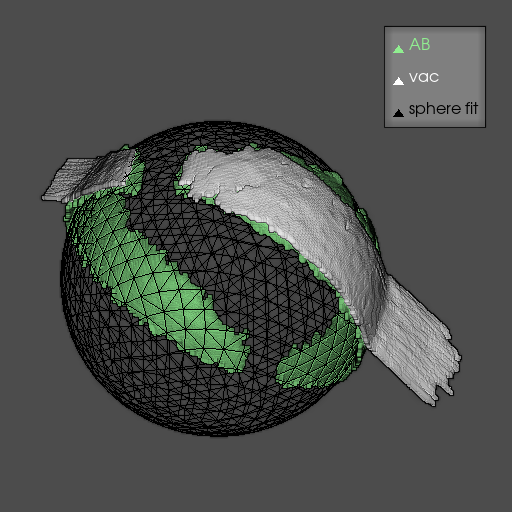

In [11]:
# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0) 
p0.enable_eye_dome_lighting()
colors = ['lightgreen', 'white']
for i, key in enumerate(['AB', 'vac']):
    p0.add_mesh(points[key], color = colors[i], label=key)
    
p0.add_mesh(d_fit['surf'], style='wireframe', color='black', label='sphere fit')
p0.add_legend()
p0.camera_position = cpos['points']
_ = p0.show()

## Find the "autophagosome" part of the vacuole

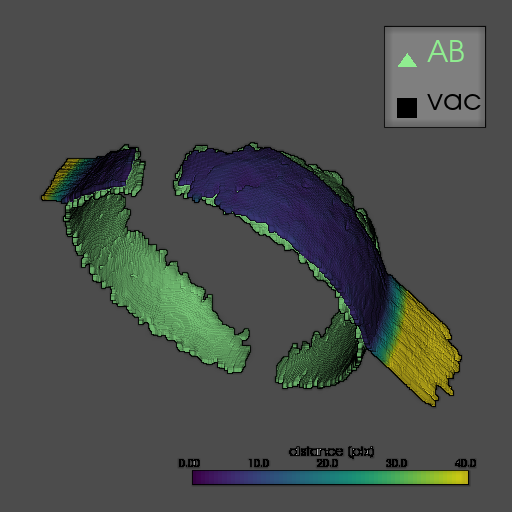

In [16]:
# Distance vacuole -> AB, no refinement
tree_AB = cKDTree(points['AB'])
dist_va_unrefined, idx_va_unrefined = tree_AB.query(points['vac'])

# Distance limits for separation, in pixels
# Adjust if needed
cutoffs = {'vac_AP': 9,
           'vac_orig': 40,
           'vac_border_mid': 40,
           'vac_border_width': 5,
           'vac_adh_to_border': 15}

# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0) 
p0.enable_eye_dome_lighting()
colors = ['lightgreen', 'white']
p0.add_mesh(points['AB'], color='lightgreen', label='AB')
p0.add_mesh(points['vac'], scalars=dist_va_unrefined, label='vac', clim=[0,cutoffs['vac_orig']])
p0.add_scalar_bar(title='distance [pix]')
p0.add_legend()
p0.camera_position = cpos['points']
_ = p0.show()

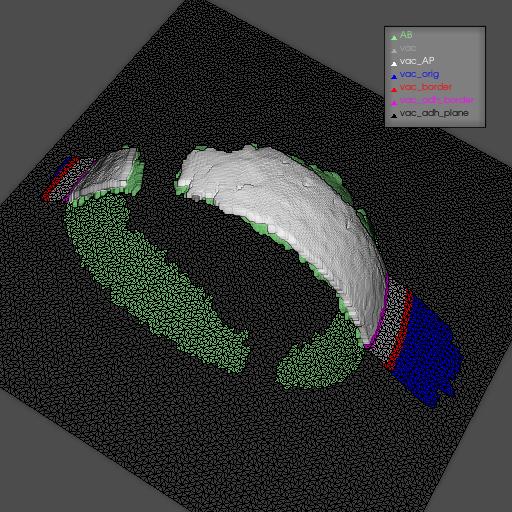

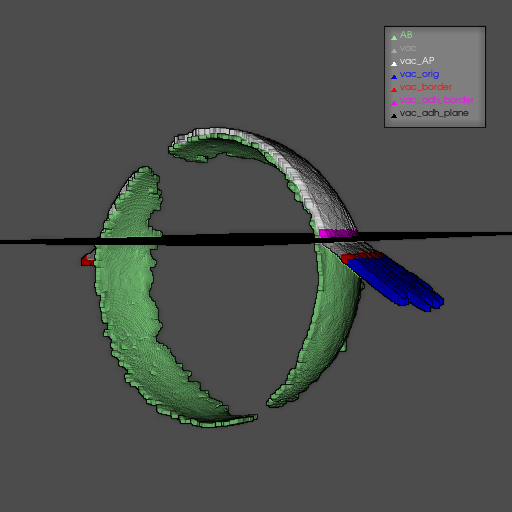

In [23]:
# Separate vac points into regions based on distance limits

# Autophagosome points (preliminary, final separation comes later): close to the AB
vac_AP_points_0 = points['vac'][abs(dist_va_unrefined) < cutoffs['vac_AP']] 
# Definitely vacuole: points very far from AB
vac_orig_points = points['vac'][abs(dist_va_unrefined) > cutoffs['vac_orig']]
vac_not_orig_points = points['vac'][abs(dist_va_unrefined) <= cutoffs['vac_orig']]
# Border: Border area, should form a ring around the AB
vac_border_points = points['vac'][abs(dist_va_unrefined - cutoffs['vac_border_mid']) < cutoffs['vac_border_width']]

# Find "adhesion border" through distance to border points
tree_border = cKDTree(vac_border_points)
dist_vacAP_border, idx_vacAP_border = tree_border.query(vac_AP_points_0)

vac_adh_border_points = vac_AP_points_0[dist_vacAP_border - dist_vacAP_border.min() < cutoffs['vac_adh_to_border']]

# Make a plane through the adhesion border points
# Reference point where plane normal should point to: Mean vac_AP point
mean_vac_AP = np.mean(vac_AP_points_0, axis=0)
adh_plane = fit_plane(vac_adh_border_points, mean_vac_AP, N_to_ref=True)

# Create a plane mesh for plotting
mesh_len = 700
plane_mesh = pv.Plane(center=adh_plane.center, direction=adh_plane.normal, 
                      i_size=mesh_len, j_size=mesh_len, i_resolution=100, j_resolution=100)
plane_mesh.triangulate(inplace=True)

# Plot (two views)
for key in ['points', 'plane']:
    p0 = pv.Plotter(notebook=True, window_size=window_size_0) 
    p0.enable_eye_dome_lighting()
    p0.add_mesh(points['AB'], color='lightgreen', label='AB')
    p0.add_mesh(points['vac'], color='darkgrey', label='vac')

    a0_AP = p0.add_mesh(vac_AP_points_0, color='white', point_size=7, label='vac_AP')
    a0_orig = p0.add_mesh(vac_orig_points, color='blue', point_size=7, label='vac_orig')
    a0_border = p0.add_mesh(vac_border_points, color='red', point_size=7, label='vac_border')
    a0_adh_border = p0.add_mesh(vac_adh_border_points, color='magenta', point_size=7, label='vac_adh_border')
    a0_adh_plane = p0.add_mesh(plane_mesh, color='black', style='wireframe', label='vac_adh_plane')
    p0.add_legend()
    p0.camera_position = cpos[key]
    _ = p0.show()
    p0.close()

## Measure intermembrane distances in the wrapped part

In [24]:
# Get all vacuole points above the adhesion border

# Find points above adh plane --> these are the "true AP" points!
ids_above_plane = np.where( np.dot(vac_not_orig_points - adh_plane.center, adh_plane.normal) > 0)[0]
vac_AP_points_1 = vac_not_orig_points[ids_above_plane]

# Get cleaned distances of AB points to AP points
dist_res0 = minimum_distance_cleaned(points['AB'], vac_AP_points_1)
points['AB_clean'] = dist_res0.a_cleaned
points['AP_clean'] = dist_res0.b_cleaned
dist_cleaned_nm = dist_res0.dist_cleaned*pix_size

cleaned distances: mean 8.3 nm, std 1.2 nm.
refined distances: mean 8.3 nm, std 0.9 nm.


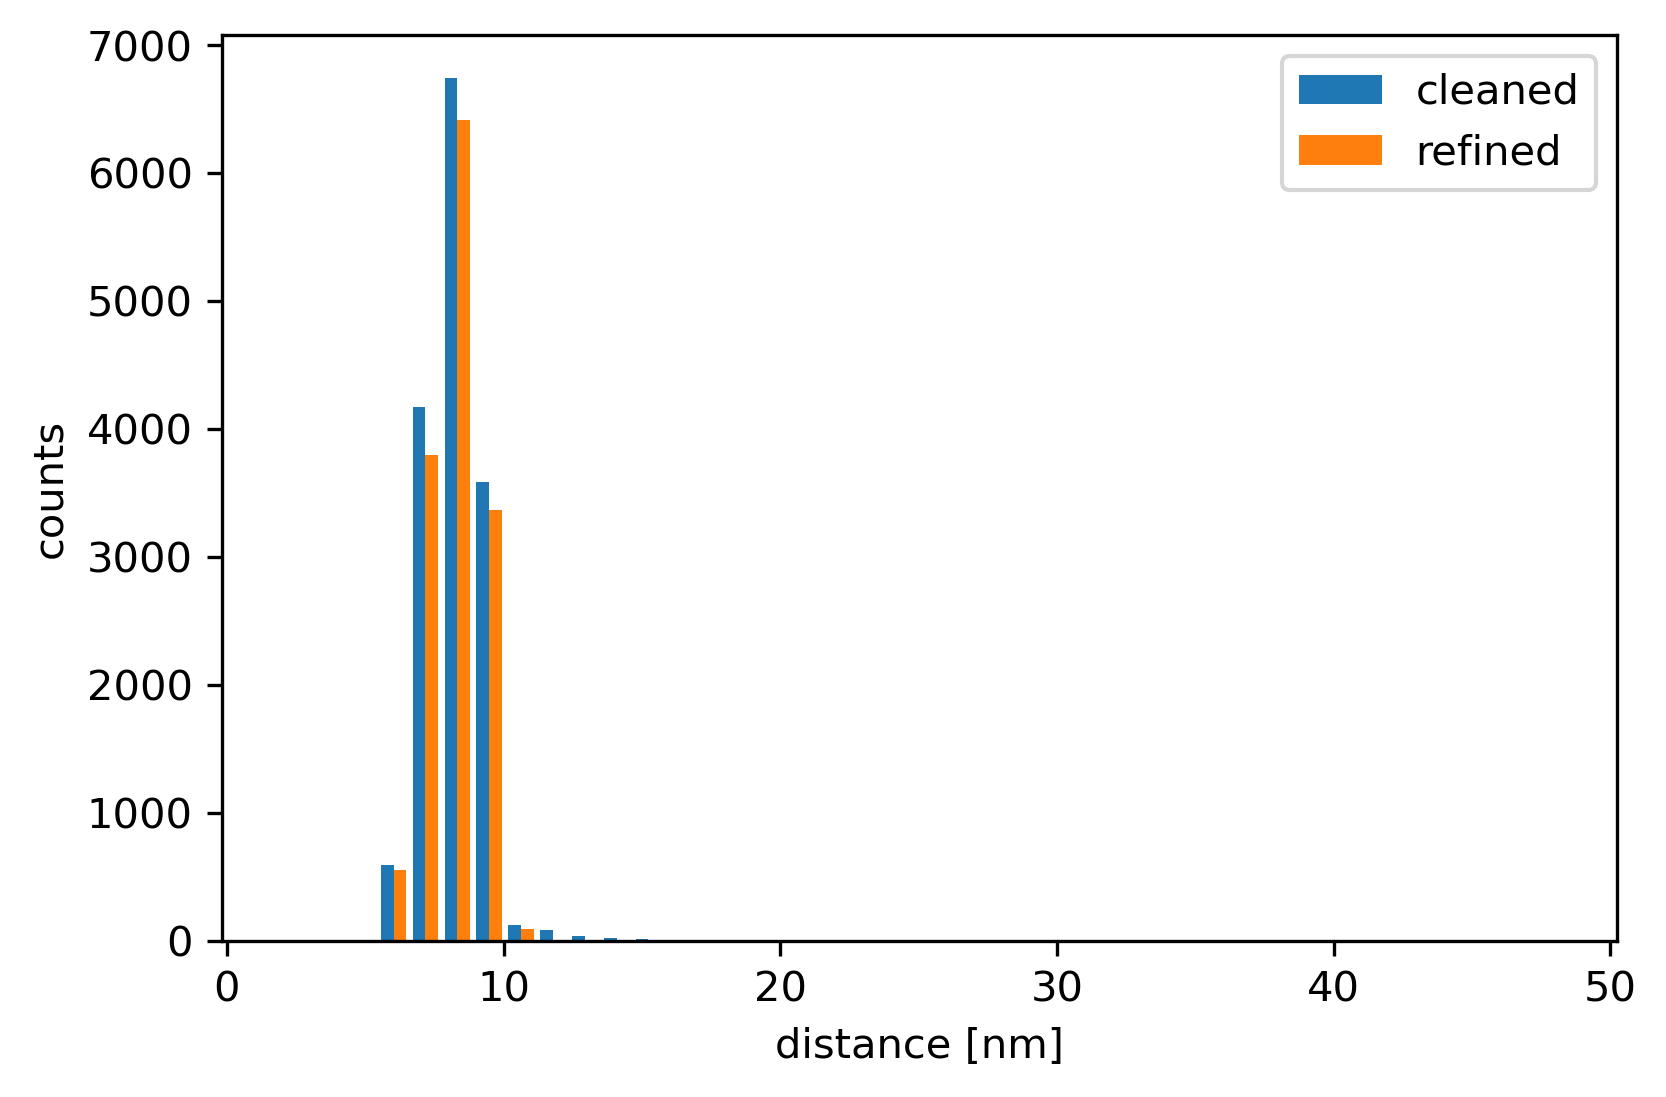

In [27]:
# Refinement of distances: AB sphere normals should be roughly parallel to AB->vac vectors

# Get normals of AB points from the fitted surface
tree_surf = cKDTree(d_fit['surf'].points)
_, idx_ab_surf = tree_surf.query(points['AB_clean'])
AB_cleaned_normals = d_fit['surf']['Normals'][idx_ab_surf]

# Calculate angle between AB->AP and surface normal
vectors_AB_AP = normalize_vector(points['AP_clean']-points['AB_clean'])    
vec_surf_angles = angle_between_vectors_batch(vectors_AB_AP, AB_cleaned_normals)

# Apply angle cutoff
surf_angle_cutoff = 20
ids_low_angle = np.where(vec_surf_angles < surf_angle_cutoff)[0]
    
# Get points and distances
points['AP_refined'] = points['AP_clean'][ids_low_angle]
points['AB_refined'] = points['AB_clean'][ids_low_angle]
dist_refined_nm = dist_cleaned_nm[ids_low_angle]

for dist_tmp, name in zip([dist_cleaned_nm, dist_refined_nm], ['cleaned', 'refined']):
    print('{} distances: mean {:.1f} nm, std {:.1f} nm.'.format(name, np.mean(dist_tmp), np.std(dist_tmp)))

# Plot distance histograms
fig, ax = plt.subplots(dpi=300, figsize=(6,4))
ax.hist([dist_cleaned_nm, dist_refined_nm], bins=40, label=['cleaned', 'refined'])
ax.legend()
ax.set_xlabel('distance [nm]')
ax.set_ylabel('counts')
plt.show()

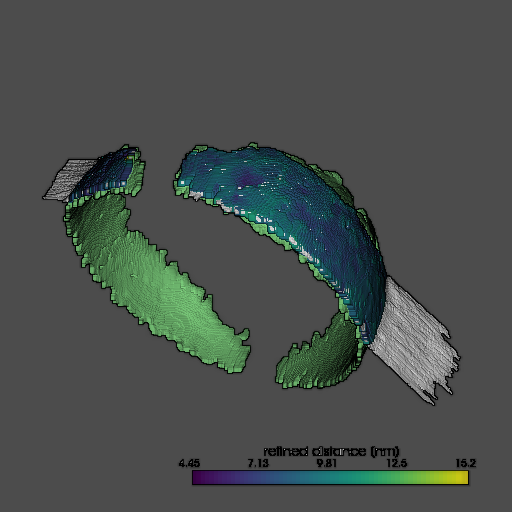

In [28]:
# Plot distances on structure
p0 = pv.Plotter(notebook=True, window_size=window_size_0) 
p0.enable_eye_dome_lighting()
p0.add_mesh(points['AB'], color='lightgreen', label='AB')
p0.add_mesh(points['vac'], color='white', label='vac', point_size=3)
p0.add_mesh(points['AP_refined'], scalars=dist_refined_nm, label='dist', point_size=7)
p0.add_scalar_bar(title='refined distance [nm]')

p0.camera_position = cpos['points']
_ = p0.show()